In [2]:
# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from OA_utils.data_utils import *
from OA_utils.eval_utils import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from OA_lstm import LSTMModel
from OA_cnnlstm import CNNLSTMModel
from OA_lstmattn import LSTMAttentionModel
from OA_transformer import TransformerModel

In [3]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [4]:
data_dir = "C:\\Users\\bakel\\Desktop\\GRFMuscleModel\\Old_Young_Walking_Data\\"

train_data = np.load(data_dir + 'mixed_train_data.npz')
val_data = np.load(data_dir + 'mixed_val_data.npz')
test_data = np.load(data_dir + 'mixed_test_data.npz')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 
                 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']
muscle_titles = ['Tibialis Posterior', 'Tibialis Anterior', 'Extensor Digitorum Longus', 'Extensor Hallucis Longus', 
                 'Flexor Digitorum Longus', 'Flexor Hallucis Longus', 'Peroneus Brevis', 'Peroneus Longus', 'Achilles']
muscle_abbrevs = ['Tib Post', 'Tib Ant', 'EDL', 'EHL', 'FDL', 'FHL', 'Per Brevis', 'Per Long', 'Achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [5]:
X_train = train_data['X_train']
y_train = train_data['y_train']
X_val = val_data['X_val']
y_val = val_data['y_val']
X_test = test_data['X_test']
y_test = test_data['y_test']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (633, 100, 3)
y_train shape: (633, 100, 9)
X_val shape: (64, 100, 3)
y_val shape: (64, 100, 9)
X_test shape: (81, 100, 3)
y_test shape: (81, 100, 9)


In [6]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [7]:
lstm_model = LSTMModel(input_size=3, 
                       hidden_size=256, 
                       num_layers=3, 
                       output_size=9, 
                       dropout= 0.33689968108169666)

lstm_model.load_state_dict(torch.load('../models/Mixed_lstm.pth', weights_only=True))

lstm_model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(lstm_model.parameters(), 
#                        lr=0.0004070688993179255, 
#                        weight_decay=4.278679617413207e-05)

LSTMModel(
  (lstm): LSTM(3, 256, num_layers=3, batch_first=True, dropout=0.33689968108169666)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [8]:
lstm_loss, lstm_pred_tensor = eval_model(lstm_model, X_test_tensor, y_test_tensor)
print(f"LSTM Loss: {lstm_loss}")

LSTM Loss: 5413.478515625


In [9]:
# y_test = y_test_tensor.cpu().numpy()
lstm_pred = lstm_pred_tensor.cpu().numpy()

lstm_rrmse = calc_rrmse_muscle(y_test, lstm_pred)

tibpost: 0.1696
tibant: 0.1241
edl: 0.1359
ehl: 0.1301
fdl: 0.1883
fhl: 0.1809
perbrev: 0.1691
perlong: 0.1504
achilles: 0.0443


In [10]:
lstm_mae = calc_mae_muscle(y_test, lstm_pred)

tibpost: 58.3353
tibant: 46.6534
edl: 17.9311
ehl: 2.4871
fdl: 3.2076
fhl: 12.0379
perbrev: 12.5571
perlong: 41.7968
achilles: 107.7131


In [11]:
lstm_r2 = calc_r2_muscle(y_test, lstm_pred)

tibpost: 0.3418
tibant: 0.5853
edl: 0.3084
ehl: 0.3799
fdl: 0.2417
fhl: 0.3018
perbrev: 0.2863
perlong: 0.3064
achilles: 0.9583


In [12]:
cnnlstm_model = CNNLSTMModel(input_size=3, 
                             hidden_size=256,
                             num_layers=2, 
                             output_size=9, 
                             dropout= 0.4389768052305767)

cnnlstm_model.load_state_dict(torch.load('../models/Mixed_cnn-lstm.pth', weights_only=True))

cnnlstm_model.to(device)

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.4389768052305767)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [13]:
cnnlstm_loss, cnnlstm_pred_tensor = eval_model(cnnlstm_model, X_test_tensor, y_test_tensor)
print(f"CNN-LSTM Loss: {cnnlstm_loss}")

CNN-LSTM Loss: 6484.36669921875


In [14]:
# y_test = y_test_tensor.cpu().numpy()
cnnlstm_pred = cnnlstm_pred_tensor.cpu().numpy()

cnnlstm_rrmse = calc_rrmse_muscle(y_test, cnnlstm_pred)

tibpost: 0.2272
tibant: 0.1249
edl: 0.1415
ehl: 0.1340
fdl: 0.2420
fhl: 0.2111
perbrev: 0.1770
perlong: 0.1593
achilles: 0.0475


In [15]:
cnnlstm_mae = calc_mae_muscle(y_test, cnnlstm_pred)

tibpost: 79.0590
tibant: 47.7800
edl: 18.5804
ehl: 2.4918
fdl: 4.0496
fhl: 14.4001
perbrev: 13.1322
perlong: 44.0989
achilles: 127.7928


In [16]:
cnnlstm_r2 = calc_r2_muscle(y_test, cnnlstm_pred)

tibpost: -0.1809
tibant: 0.5800
edl: 0.2497
ehl: 0.3421
fdl: -0.2527
fhl: 0.0490
perbrev: 0.2176
perlong: 0.2213
achilles: 0.9521


In [17]:
lstmattn_model = LSTMAttentionModel(input_size=3, 
                                    hidden_size=256, 
                                    num_layers=3, 
                                    num_heads=4, 
                                    output_size=9, 
                                    lstm_dropout=  0.2780800787060336, 
                                    attn_dropout= 0.0906586648086)

lstmattn_model.load_state_dict(torch.load('../models/OA_no_missteps_lstm-attn.pth', weights_only=True))

lstmattn_model.to(device)

LSTMAttentionModel(
  (lstm): LSTM(3, 256, num_layers=3, batch_first=True, dropout=0.2780800787060336)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [18]:
lstmattn_loss, lstmattn_pred_tensor = eval_model(lstmattn_model, X_test_tensor, y_test_tensor)
print(f"LSTM-Attention Loss: {lstmattn_loss}")

LSTM-Attention Loss: 5532.57861328125


In [19]:
lstmattn_pred = lstmattn_pred_tensor.cpu().numpy()

lstmattn_rrmse = calc_rrmse_muscle(y_test, lstmattn_pred)

tibpost: 0.2287
tibant: 0.1405
edl: 0.1647
ehl: 0.1568
fdl: 0.3036
fhl: 0.2265
perbrev: 0.2058
perlong: 0.1697
achilles: 0.0394


In [20]:
lstmattn_mae = calc_mae_muscle(y_test, lstmattn_pred)

tibpost: 81.3457
tibant: 54.6735
edl: 23.9546
ehl: 3.7934
fdl: 5.5161
fhl: 17.0673
perbrev: 15.1798
perlong: 47.2439
achilles: 115.6886


In [21]:
lstmattn_r2= calc_r2_muscle(y_test, lstmattn_pred)

tibpost: -0.1960
tibant: 0.4678
edl: -0.0157
ehl: 0.0991
fdl: -0.9716
fhl: -0.0951
perbrev: -0.0570
perlong: 0.1165
achilles: 0.9671


In [22]:
transformer_model = TransformerModel(input_dim=3,
                                     output_dim=9, 
                                     d_model=128, 
                                     nhead=8, 
                                     num_encoder_layers=6, 
                                     dim_feedforward=256, 
                                     dropout= 0.004858344076458243)

transformer_model.load_state_dict(torch.load('../models/Mixed_transformer.pth', weights_only=True))

transformer_model.to(device)

TransformerModel(
  (input_embedding): Linear(in_features=3, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.004858344076458243, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.004858344076458243, inplace=False)
        (dropout2): Dropout(p=0.004858344076458243, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=9, bias=True)
)

In [23]:
transformer_loss, transformer_pred_tensor = eval_model(transformer_model, X_test_tensor, y_test_tensor)
print(f"Transformer Loss: {transformer_loss}")

Transformer Loss: 709.6591186523438


In [24]:
transformer_pred = transformer_pred_tensor.cpu().numpy()

transformer_rrmse = calc_rrmse_muscle(y_test, transformer_pred)

tibpost: 0.0596
tibant: 0.0482
edl: 0.0586
ehl: 0.0645
fdl: 0.0866
fhl: 0.0737
perbrev: 0.0654
perlong: 0.0493
achilles: 0.0159


In [25]:
transformer_mae = calc_mae_muscle(y_test, transformer_pred)

tibpost: 18.7772
tibant: 16.8795
edl: 7.9794
ehl: 1.3029
fdl: 1.3924
fhl: 4.6116
perbrev: 4.9440
perlong: 13.8091
achilles: 31.9473


In [26]:
transformer_r2 = calc_r2_muscle(y_test, transformer_pred)

tibpost: 0.9188
tibant: 0.9374
edl: 0.8713
ehl: 0.8477
fdl: 0.8396
fhl: 0.8842
perbrev: 0.8931
perlong: 0.9253
achilles: 0.9946


In [27]:
lstm_rmse_overall = calc_rmse_overall(y_test, lstm_pred)
print(f"LSTM RMSE Overall: {lstm_rmse_overall}")

cnnlstm_rmse_overall = calc_rmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSE Overall: {cnnlstm_rmse_overall}")

lstmattn_rmse_overall = calc_rmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSE Overall: {lstmattn_rmse_overall}")

transformer_rmse_overall = calc_rmse_overall(y_test, transformer_pred)
print(f"Transformer RMSE Overall: {transformer_rmse_overall}")

LSTM RMSE Overall: 73.57634606883441
CNN-LSTM RMSE Overall: 80.5255663526667
LSTM-Attention RMSE Overall: 74.38130834631717
Transformer RMSE Overall: 26.63942780552917


In [28]:
lstm_rrmse_overall = calc_rrmse_overall(y_test, lstm_pred)
print(f"LSTM RRMSE Overall: {lstm_rrmse_overall}")

cnnlstm_rrmse_overall = calc_rrmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Overall: {cnnlstm_rrmse_overall}")

lstmattn_rrmse_overall = calc_rrmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Overall: {lstmattn_rrmse_overall}")

transformer_rrmse_overall = calc_rrmse_overall(y_test, transformer_pred)
print(f"Transformer RRMSE Overall: {transformer_rrmse_overall}")

LSTM RRMSE Overall: 0.017924644858517597
CNN-LSTM RRMSE Overall: 0.01961761158337733
LSTM-Attention RRMSE Overall: 0.01812074949974133
Transformer RRMSE Overall: 0.006489888505763816


In [29]:
lstm_rrmse_weighted = calc_rrmse_weighted(y_test, lstm_pred)
print(f"LSTM RRMSE Weighted: {lstm_rrmse_weighted}")

cnnlstm_rrmse_weighted = calc_rrmse_weighted(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Weighted: {cnnlstm_rrmse_weighted}")

lstmattn_rrmse_weighted = calc_rrmse_weighted(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Weighted: {lstmattn_rrmse_weighted}")

transformer_rrmse_weighted = calc_rrmse_weighted(y_test, transformer_pred)
print(f"Transformer RRMSE Weighted: {transformer_rrmse_weighted}")

LSTM RRMSE Weighted: 0.07793136171683594
CNN-LSTM RRMSE Weighted: 0.08586820477862496
LSTM-Attention RRMSE Weighted: 0.08490299834708125
Transformer RRMSE Weighted: 0.02874378535956452


In [30]:
lstm_rmspe = calc_rmspe_overall(y_test, lstm_pred)
print(f"LSTM RMSPE: {lstm_rmspe}")

cnnlstm_rmspe = calc_rmspe_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSPE: {cnnlstm_rmspe}")

lstmattn_rmspe = calc_rmspe_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSPE: {lstmattn_rmspe}")

transformer_rmspe = calc_rmspe_overall(y_test, transformer_pred)
print(f"Transformer RMSPE: {transformer_rmspe}")

LSTM RMSPE: 0.7952617446683187
CNN-LSTM RMSPE: 0.9268228497560037
LSTM-Attention RMSPE: 1.1029517839308232
Transformer RMSPE: 0.38683616029343804


In [31]:
lstm_mae_overall = calc_mae_overall(y_test, lstm_pred)
print(f"LSTM MAE Overall: {lstm_mae_overall}")

cnnlstm_mae_overall = calc_mae_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM MAE Overall: {cnnlstm_mae_overall}")

lstmattn_mae_overall = calc_mae_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention MAE Overall: {lstmattn_mae_overall}")

transformer_mae_overall = calc_mae_overall(y_test, transformer_pred)
print(f"Transformer MAE Overall: {transformer_mae_overall}")

LSTM MAE Overall: 33.63549551828288
CNN-LSTM MAE Overall: 39.042738337973866
LSTM-Attention MAE Overall: 40.49586908416624
Transformer MAE Overall: 11.29369894909593


In [32]:
lstm_mae_weighted = calc_mae_weighted(y_test, lstm_pred)
print(f"LSTM MAE Weighted: {lstm_mae_weighted}")

cnnlstm_mae_weighted = calc_mae_weighted(y_test, cnnlstm_pred)
print(f"CNN-LSTM MAE Weighted: {cnnlstm_mae_weighted}")

lstmattn_mae_weighted = calc_mae_weighted(y_test, lstmattn_pred)
print(f"LSTM-Attention MAE Weighted: {lstmattn_mae_weighted}")

transformer_mae_weighted = calc_mae_weighted(y_test, transformer_pred)
print(f"Transformer MAE Weighted: {transformer_mae_weighted}")

LSTM MAE Weighted: 0.05045047014192959
CNN-LSTM MAE Weighted: 0.058560888562157715
LSTM-Attention MAE Weighted: 0.06074046487561647
Transformer MAE Weighted: 0.016939617295472886


In [33]:
lstm_r2_overall = calc_r2_overall(y_test, lstm_pred)
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = calc_r2_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = calc_r2_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = calc_r2_overall(y_test, transformer_pred)
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.9649422646087517
CNN-LSTM R2: 0.9580071836810575
LSTM-Attention R2: 0.9641709698274598
Transformer R2: 0.995404241375156


In [34]:
from sklearn.metrics import r2_score

lstm_r2_overall = r2_score(y_test.flatten(), lstm_pred.flatten())
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = r2_score(y_test.flatten(), cnnlstm_pred.flatten())
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = r2_score(y_test.flatten(), lstmattn_pred.flatten())
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = r2_score(y_test.flatten(), transformer_pred.flatten())
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.9649422646087517
CNN-LSTM R2: 0.9580071836810575
LSTM-Attention R2: 0.9641709698274598
Transformer R2: 0.995404241375156


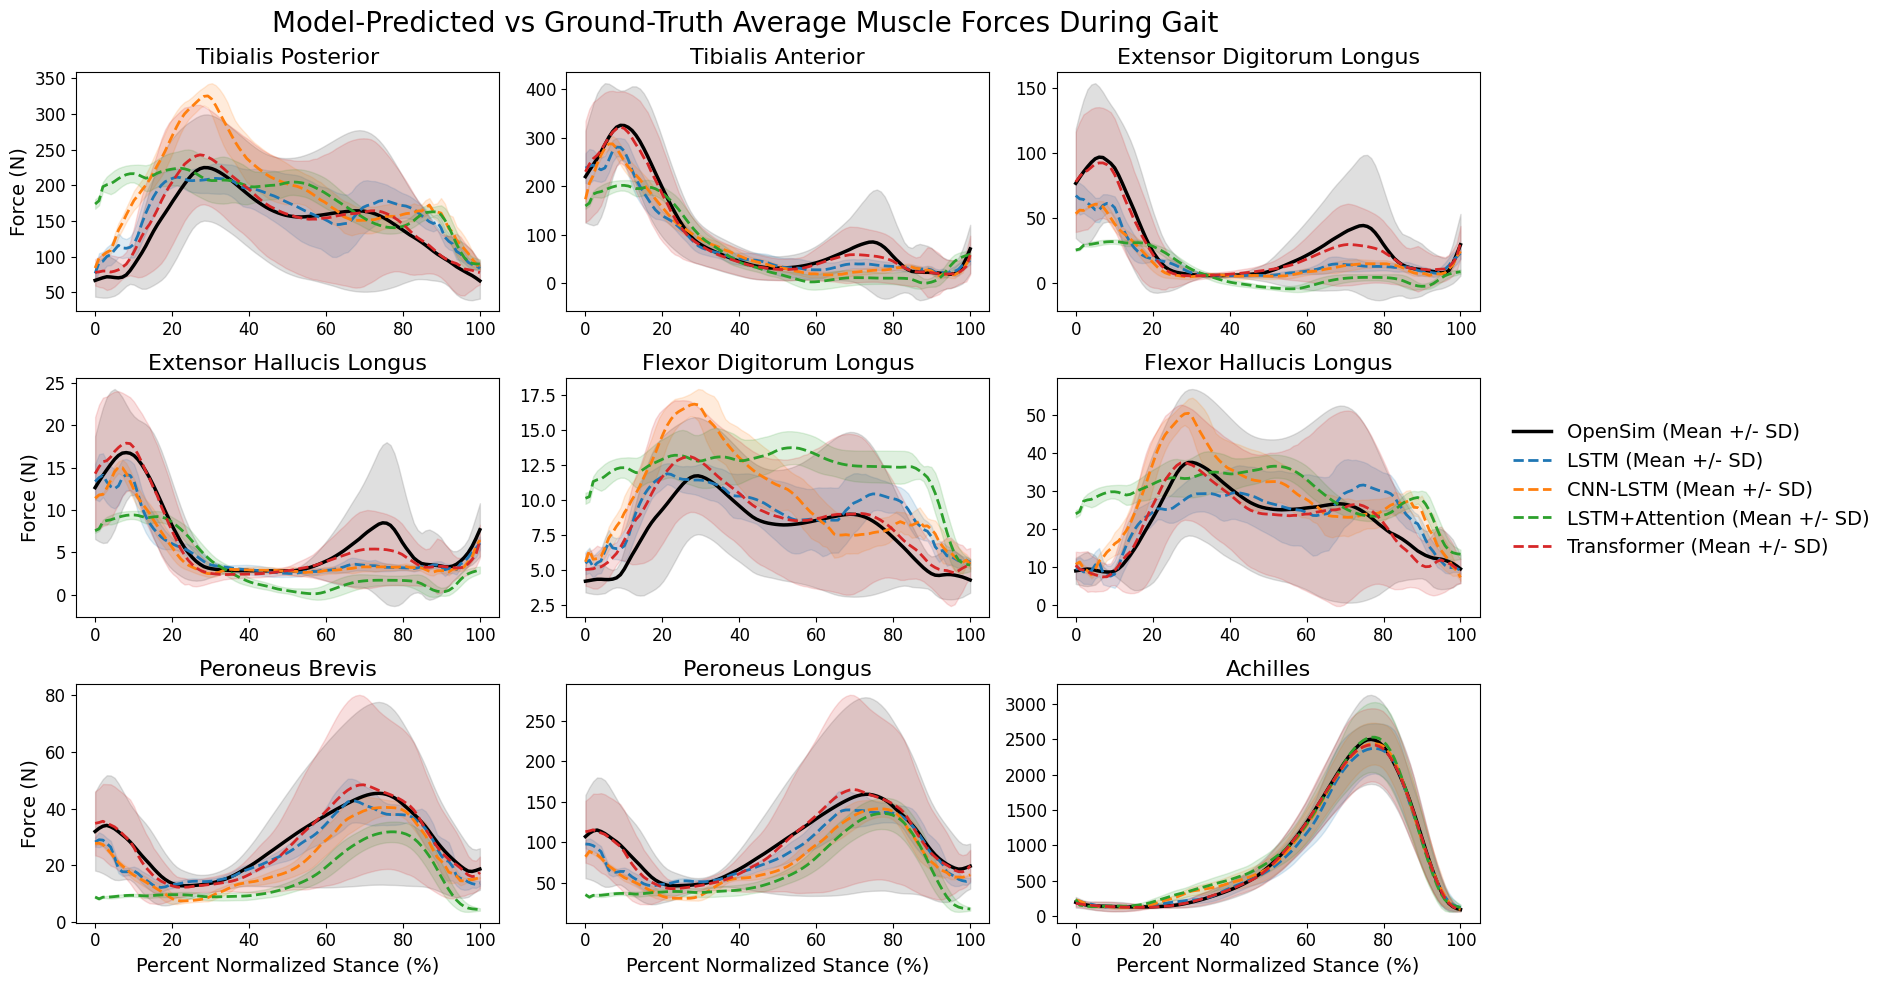

In [53]:
# Ground truth stats
true_mean = np.mean(y_test, axis=0)      
true_std  = np.std(y_test, axis=0)      

# Model stats
lstm_mean  = np.mean(lstm_pred, axis=0)
lstm_std   = np.std(lstm_pred, axis=0)

cnn_mean   = np.mean(cnnlstm_pred, axis=0)
cnn_std    = np.std(cnnlstm_pred, axis=0)

attn_mean  = np.mean(lstmattn_pred, axis=0)
attn_std   = np.std(lstmattn_pred, axis=0)

trans_mean = np.mean(transformer_pred, axis=0)
trans_std  = np.std(transformer_pred, axis=0)

pred_means = [lstm_mean, cnn_mean, attn_mean, trans_mean]
pred_stds  = [lstm_std, cnn_std, attn_std, trans_std]
perc_stance = np.linspace(0, 100, 100)
model_labels = ['LSTM (Mean +/- SD)', 'CNN-LSTM (Mean +/- SD)', 'LSTM+Attention (Mean +/- SD)', 'Transformer (Mean +/- SD)']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(perc_stance, true_mean[:, i], label='OpenSim (Mean +/- SD)', color='black', linewidth=2.5)
    ax.fill_between(
        perc_stance,
        true_mean[:, i] - true_std[:, i],
        true_mean[:, i] + true_std[:, i],
        color='gray', alpha=0.25
    )
    for j, (pred_m, pred_s) in enumerate(zip(pred_means, pred_stds)):
        
        ax.plot(perc_stance, pred_m[:, i],
                label=model_labels[j], color=colors[j], linewidth=2, linestyle = '--')

        ax.fill_between(
            perc_stance,
            pred_m[:, i] - pred_s[:, i],
            pred_m[:, i] + pred_s[:, i],
            color=colors[j], alpha=0.15
        )

    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance (%)', fontsize=14)
    if i % 3 == 0:
        ax.set_ylabel('Force (N)', fontsize=14)

    ax.set_title(muscle_titles[i], fontsize=16)
    # if i == 1:
    #     ax.legend(loc='upper right', fontsize=10, frameon=True)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
handles, labels = axes[0].get_legend_handles_labels()

fig.legend(
    handles, labels,
    loc='center left',      
    ncol=1,                    
    fontsize=14,
    frameon=False,
    bbox_to_anchor=(1, 0.5)  
)

plt.suptitle('Model-Predicted vs Ground-Truth Average Muscle Forces During Gait', fontsize = 20)
plt.tight_layout()
plt.show()


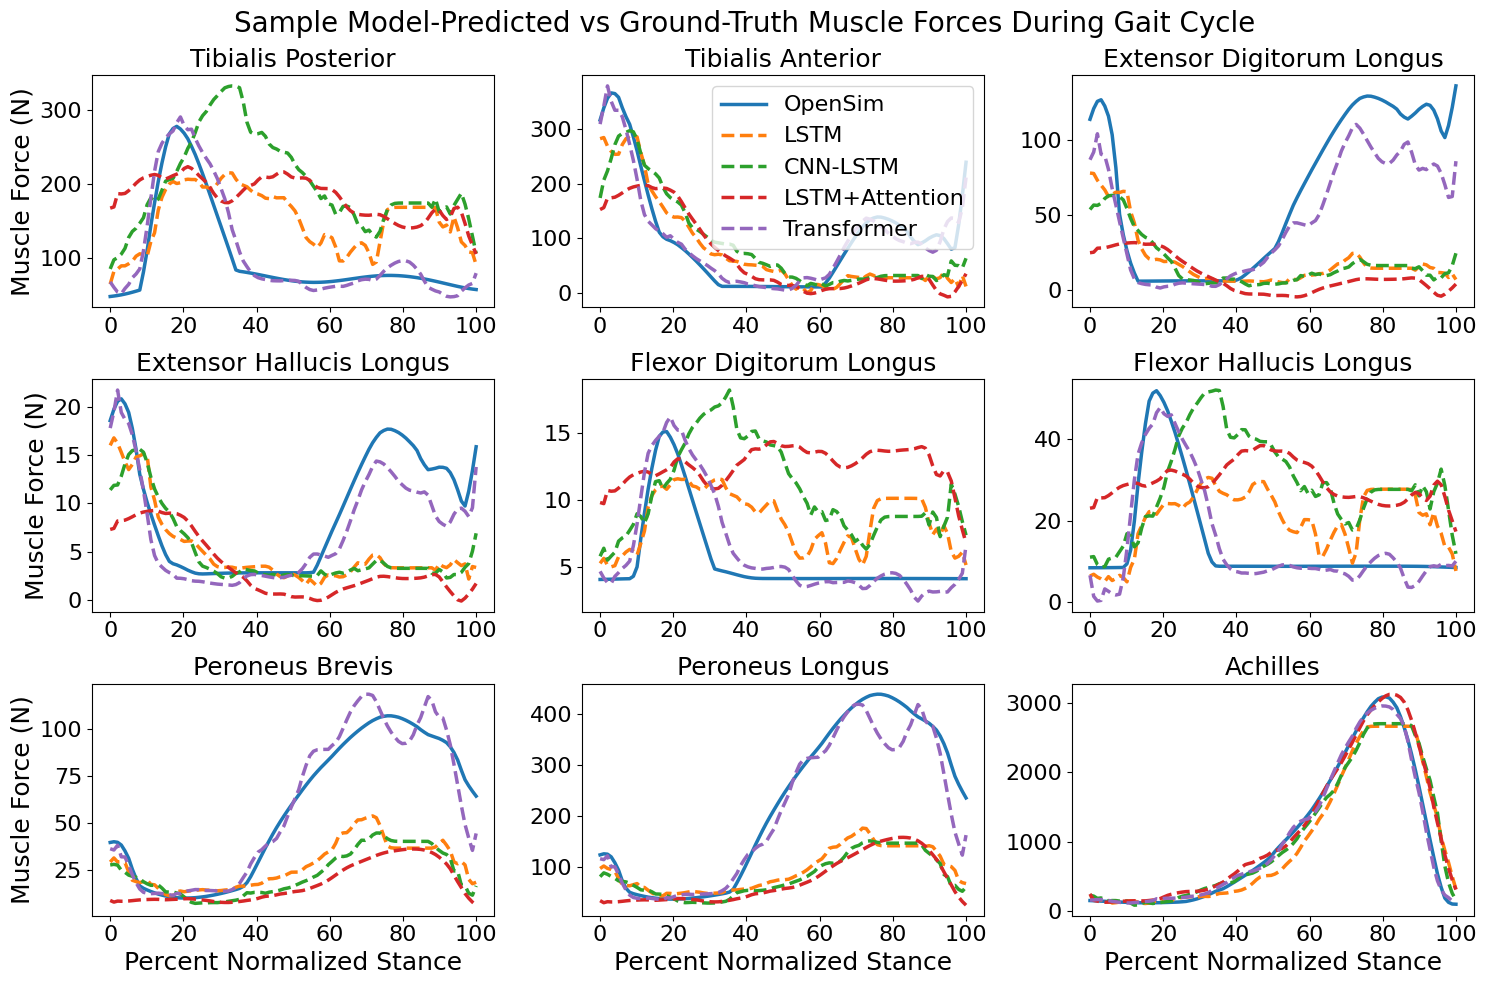

In [50]:
sample_idx = 69

preds = [lstm_pred[sample_idx], cnnlstm_pred[sample_idx], lstmattn_pred[sample_idx], transformer_pred[sample_idx]]
true = y_test[sample_idx]

perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(perc_stance, true[:, i], label='OpenSim', linewidth=2.5)
    
    for j, pred in enumerate(preds):
        ax.plot(perc_stance, pred[:, i], label=model_labels[j], linewidth=2.5, linestyle='--')
        
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=18)
        
    if i % 3 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=18)
        
    ax.set_title(muscle_titles[i], fontsize=18)
    if i == 1:
        ax.legend(loc='upper right', fontsize=16, frameon=True)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    handles, labels = axes[0].get_legend_handles_labels()

# fig.legend(
#     handles, labels,
#     loc='center left',      
#     ncol=1,                    
#     fontsize=16,
#     frameon=False,
#     bbox_to_anchor=(1, 0.5)  
# )

plt.suptitle('Sample Model-Predicted vs Ground-Truth Muscle Forces During Gait Cycle', fontsize = 20)
plt.tight_layout()
plt.show()


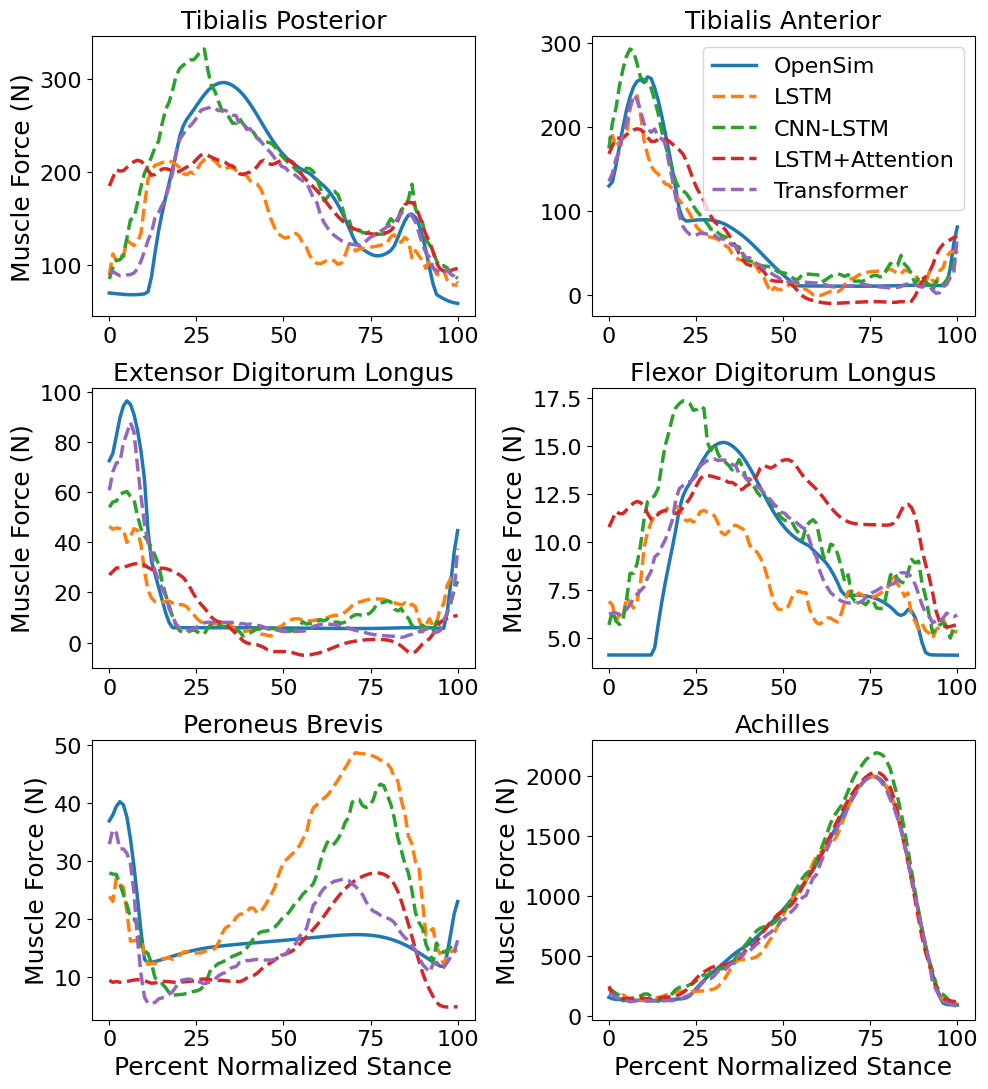

In [37]:
sample_idx = 0

preds = [lstm_pred[sample_idx], cnnlstm_pred[sample_idx], lstmattn_pred[sample_idx], transformer_pred[sample_idx]]
true = y_test[sample_idx]

perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

plot_idx = [0, 1, 2, 4, 6, 8]

fig, axes = plt.subplots(3, 2, figsize=(10, 11))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in zip(plot_idx, axes):
    ax.plot(perc_stance, true[:, i], label='OpenSim', linewidth=2.5)
    
    for j, pred in enumerate(preds):
        ax.plot(perc_stance, pred[:, i], label=model_labels[j], linewidth=2.5, linestyle='--')
        
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=18)
        
    if i % 2 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=18)
        
    ax.set_title(muscle_titles[i], fontsize=18)
    if i == 1:
        ax.legend(loc='upper right', fontsize=16, frameon=True)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()


In [64]:
rrmse_muscle_dict = {'LSTM': lstm_rrmse, 'CNN-LSTM': cnnlstm_rrmse, 'LSTM+Attention': lstmattn_rrmse, 'Transformer': transformer_rrmse}
rrmse_overall_dict = {'LSTM': lstm_rrmse_weighted, 'CNN-LSTM': cnnlstm_rrmse_weighted, 'LSTM+Attention': lstmattn_rrmse_weighted, 'Transformer': transformer_rrmse_weighted}

rrmse_table = generate_latex_table(rrmse_muscle_dict, rrmse_overall_dict, muscle_titles)
print(rrmse_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.1696 & 0.2272 & 0.2287 & 0.0596 \\
{Tibialis Anterior} & 0.1241 & 0.1249 & 0.1405 & 0.0482 \\
{Extensor Digitorum Longus} & 0.1359 & 0.1415 & 0.1647 & 0.0586 \\
{Extensor Hallucis Longus} & 0.1301 & 0.1340 & 0.1568 & 0.0645 \\
{Flexor Digitorum Longus} & 0.1883 & 0.2420 & 0.3036 & 0.0866 \\
{Flexor Hallucis Longus} & 0.1809 & 0.2111 & 0.2265 & 0.0737 \\
{Peroneus Brevis} & 0.1691 & 0.1770 & 0.2058 & 0.0654 \\
{Peroneus Longus} & 0.1504 & 0.1593 & 0.1697 & 0.0493 \\
{Achilles} & 0.0443 & 0.0475 & 0.0394 & 0.0159 \\
\midrule
Overall & 0.0779 & 0.0859 & 0.0849 & 0.0287 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [65]:
mae_muscle_dict = {'LSTM': lstm_mae, 'CNN-LSTM': cnnlstm_mae, 'LSTM+Attention': lstmattn_mae, 'Transformer': transformer_mae}
mae_overall_dict = {'LSTM': lstm_mae_weighted, 'CNN-LSTM': cnnlstm_mae_weighted, 'LSTM+Attention': lstmattn_mae_weighted, 'Transformer': transformer_mae_weighted}

mae_table = generate_latex_table(mae_muscle_dict, mae_overall_dict, muscle_titles)
print(mae_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 58.3353 & 79.0590 & 81.3457 & 18.7772 \\
{Tibialis Anterior} & 46.6534 & 47.7800 & 54.6735 & 16.8795 \\
{Extensor Digitorum Longus} & 17.9311 & 18.5804 & 23.9546 & 7.9794 \\
{Extensor Hallucis Longus} & 2.4871 & 2.4918 & 3.7934 & 1.3029 \\
{Flexor Digitorum Longus} & 3.2076 & 4.0496 & 5.5161 & 1.3924 \\
{Flexor Hallucis Longus} & 12.0379 & 14.4001 & 17.0673 & 4.6116 \\
{Peroneus Brevis} & 12.5571 & 13.1322 & 15.1798 & 4.9440 \\
{Peroneus Longus} & 41.7968 & 44.0989 & 47.2439 & 13.8091 \\
{Achilles} & 107.7131 & 127.7928 & 115.6886 & 31.9473 \\
\midrule
Overall & 0.0505 & 0.0586 & 0.0607 & 0.0169 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [66]:
r2_muscle_dict = {'LSTM': lstm_r2, 'CNN-LSTM': cnnlstm_r2, 'LSTM+Attention': lstmattn_r2, 'Transformer': transformer_r2}
r2_overall_dict = {'LSTM': lstm_r2_overall, 'CNN-LSTM': cnnlstm_r2_overall, 'LSTM+Attention': lstmattn_r2_overall, 'Transformer': transformer_r2_overall}

r2_table = generate_latex_table(r2_muscle_dict, r2_overall_dict, muscle_titles)
print(r2_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.3418 & -0.1809 & -0.1960 & 0.9188 \\
{Tibialis Anterior} & 0.5853 & 0.5800 & 0.4678 & 0.9374 \\
{Extensor Digitorum Longus} & 0.3084 & 0.2497 & -0.0157 & 0.8713 \\
{Extensor Hallucis Longus} & 0.3799 & 0.3421 & 0.0991 & 0.8477 \\
{Flexor Digitorum Longus} & 0.2417 & -0.2527 & -0.9716 & 0.8396 \\
{Flexor Hallucis Longus} & 0.3018 & 0.0490 & -0.0951 & 0.8842 \\
{Peroneus Brevis} & 0.2863 & 0.2176 & -0.0570 & 0.8931 \\
{Peroneus Longus} & 0.3064 & 0.2213 & 0.1165 & 0.9253 \\
{Achilles} & 0.9583 & 0.9521 & 0.9671 & 0.9946 \\
\midrule
Overall & 0.9649 & 0.9580 & 0.9642 & 0.9954 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [77]:
# Settings
muscles = [muscle_abbrevs[i] for i in range(9)]  # Labels for muscles
muscles += ['Overall']  # Add overall R^2
models = list(r2_muscle_dict.keys())
x = np.arange(len(muscles))  # Muscle indices for the x-axis

bar_width = 0.2  # Width of each bar
offsets = np.arange(len(models)) * bar_width  # Offsets for grouped bars

colors = {
    'LSTM': 'C1',
    'CNN-LSTM': 'C2',
    'LSTM+Attention': 'C3',
    'Transformer': 	'C4'
}

for model in models:
    r2_muscle_dict[model] = list(r2_muscle_dict[model])  # Ensure it's a list
    r2_muscle_dict[model].append(r2_overall_dict[model])  # Append overall R^2

    rrmse_muscle_dict[model] = list(rrmse_muscle_dict[model])  # Ensure it's a list
    rrmse_muscle_dict[model].append(rrmse_overall_dict[model])  # Append overall RRMSE

    mae_muscle_dict[model] = list(mae_muscle_dict[model])
    mae_muscle_dict[model].append(mae_overall_dict[model])



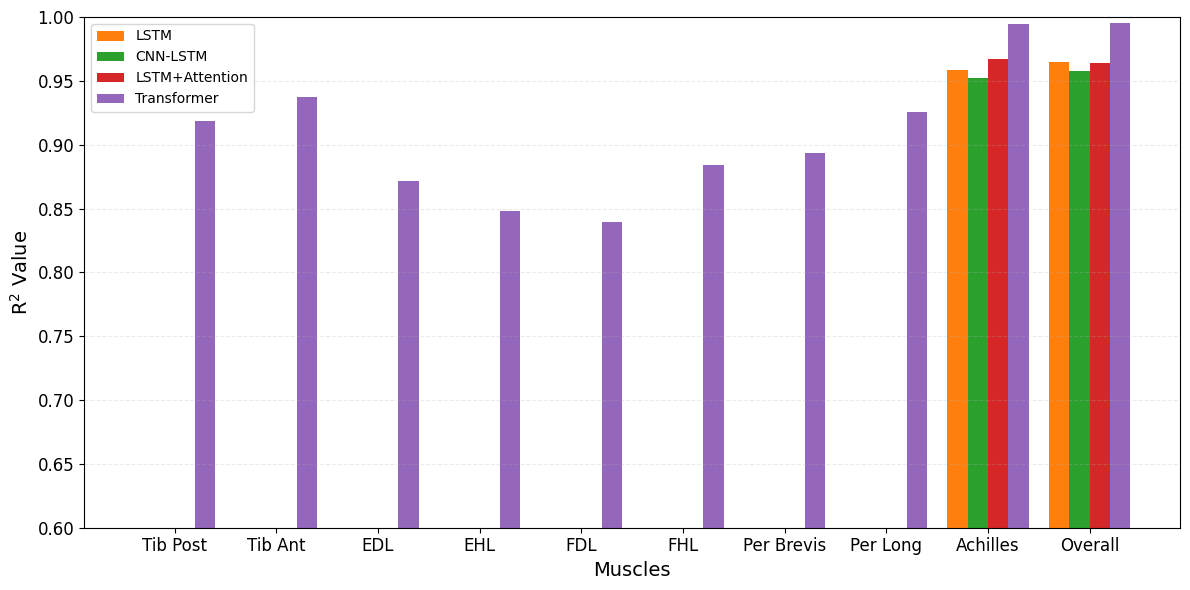

In [68]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], r2_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('R$^2$ Value', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()

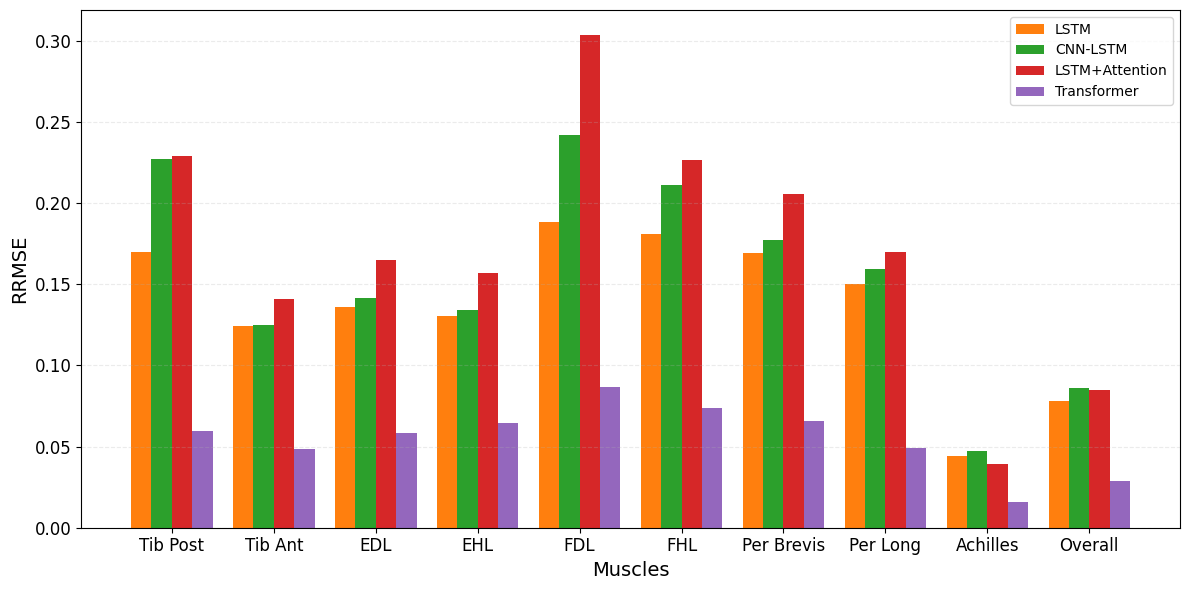

In [69]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], rrmse_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('RRMSE', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()

In [72]:
print(mae_muscle_dict)

{'LSTM': array([ 58.33528489,  46.65340264,  17.93109128,   2.48712867,
         3.2076258 ,  12.03786028,  12.55709495,  41.79684846,
       107.71312268]), 'CNN-LSTM': array([ 79.05899541,  47.7799536 ,  18.58039551,   2.49176315,
         4.04960342,  14.40007231,  13.13216321,  44.09889756,
       127.79280086]), 'LSTM+Attention': array([ 81.34565903,  54.67347933,  23.9546468 ,   3.79341641,
         5.51611505,  17.06727183,  15.17981274,  47.24385138,
       115.68856918]), 'Transformer': array([18.77716049, 16.87948256,  7.9794325 ,  1.30292797,  1.392418  ,
        4.61158234,  4.94395786, 13.80906143, 31.94726741])}


In [76]:
print(x)

[0 1 2 3 4 5 6 7 8 9]


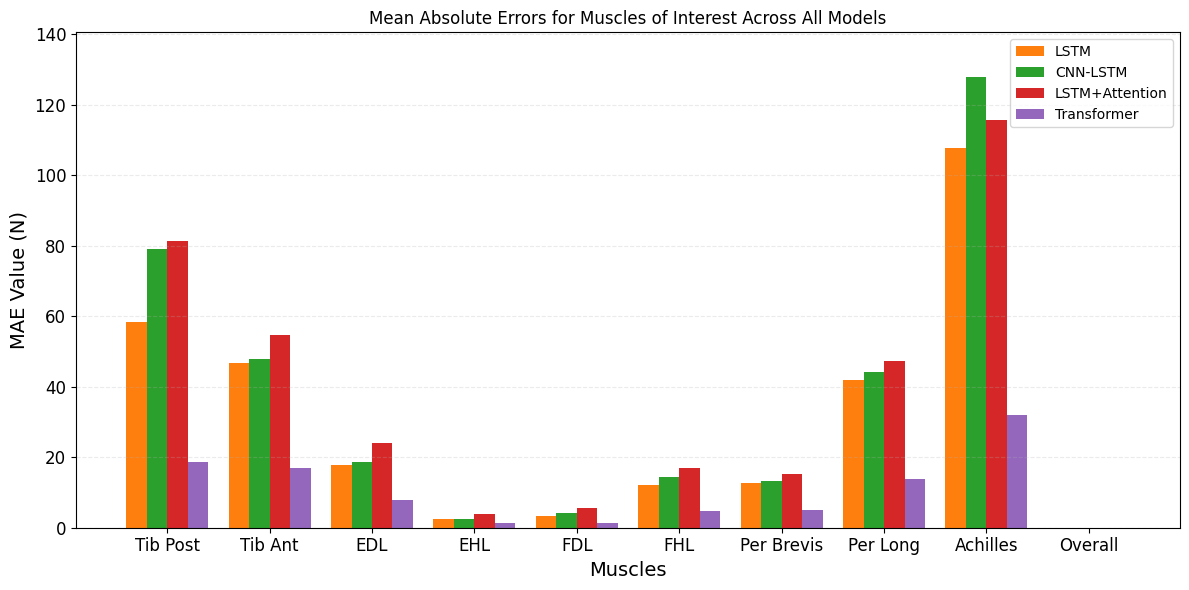

In [80]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], mae_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('MAE Value (N)', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(max(v) for v in mae_muscle_dict.values()) * 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.title('Mean Absolute Errors for Muscles of Interest Across All Models')
plt.tight_layout()
plt.show()